<a href="https://colab.research.google.com/github/goldenfries100/171Group14/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
###importing and downloading necessary libraries for running the model
! pip install scikeras
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from collections import Counter
import tensorflow as tf
import torch
import torchvision
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scikeras.wrappers import KerasClassifier
import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import save_model, load_model
import cv2
from mlxtend.evaluate import scoring
import seaborn as sb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
### cloning from the github repo and extracting the data
try:
    from google.colab import drive
    IN_COLAB = True
    drive.mount('/content/drive')
    ! git clone https://github.com/goldenfries100/171Group14 data
except:
    IN_COLAB = False

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

if IN_COLAB:
    head = r'/content/data/'
else:
    head = r'./'
file = head + r'cifar-10-batches-py/batches.meta'
batches_meta_file = unpickle(file)
print(batches_meta_file)

Mounted at /content/drive
Cloning into 'data'...
remote: Enumerating objects: 383, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 383 (delta 44), reused 8 (delta 4), pack-reused 290
Receiving objects: 100% (383/383), 215.24 MiB | 19.72 MiB/s, done.
Resolving deltas: 100% (192/192), done.
Updating files: 100% (43/43), done.
{'num_cases_per_batch': 10000, 'label_names': ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], 'num_vis': 3072}


### EDA(Exploratory Data Analysis)

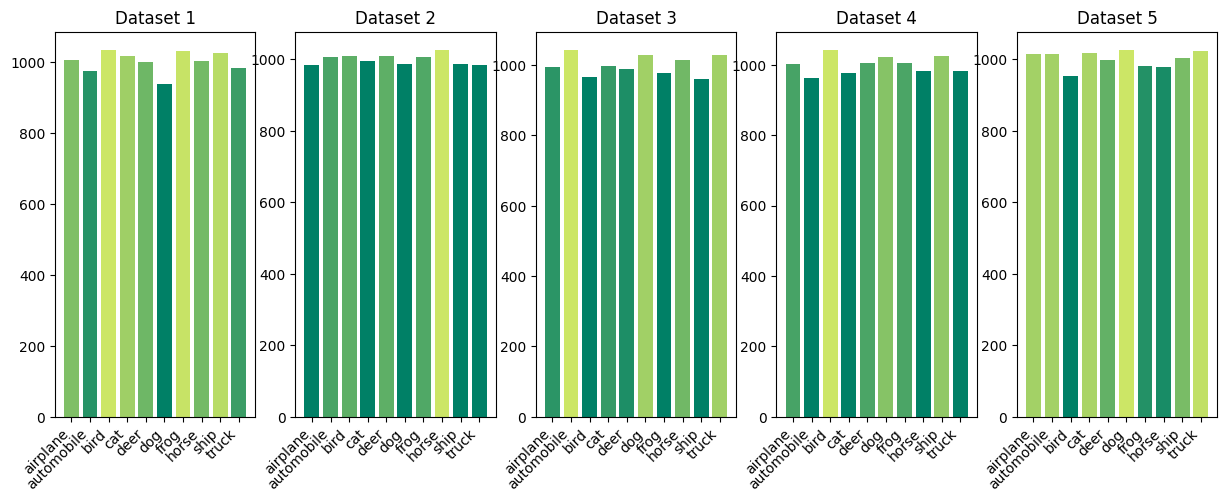

--- The total number of each class in the entire dataset is equal ---


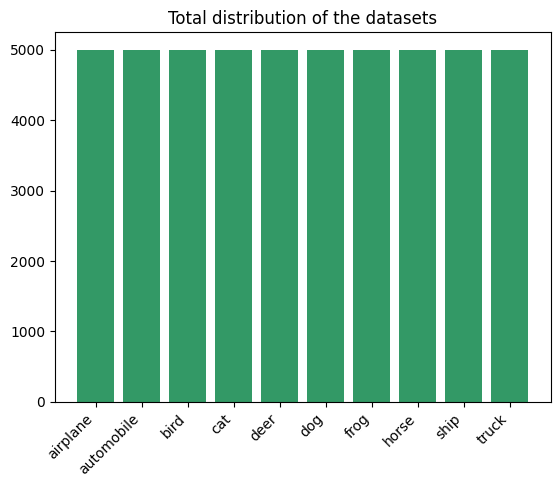

In [ ]:
### Plotting the histogram for the distribution of images for each label in the dataset.

NUM_DATASETS = 5
num_cases_per_batch = batches_meta_file['num_cases_per_batch']
label_names = batches_meta_file['label_names']
# random shuffling of data indices
random_image_indexes = (random.sample(range(num_cases_per_batch), num_cases_per_batch))
# complete dataset array
dataset_array = []
# the primary data in the dataset, contains a 50000 length array of 32x32x3 0-255 RGB values
images = []
# class labels for each image, a 50000 array of ints 0-9 corresponding to indices into label_names
labels = []
# iterate over each dataset
for i in range(NUM_DATASETS):
  # read i-th dataset from file
  dataset_array.append(unpickle(head + f'cifar-10-batches-py/data_batch_{i+1}'))
  # reshape the images into readable RGB pixel format
  dataset_array[i]['data']
  # shuffle the images according to the random image indexes generated above
  images.append(dataset_array[i]['data'][random_image_indexes].reshape(num_cases_per_batch, 3, 32, 32).transpose(0, 2, 3, 1))
  # insert labels into labels list
  labels.append([dataset_array[i]['labels'][random_index] for random_index in random_image_indexes])

# convert to np array
labels = np.asarray(labels)
images = np.asarray(images).reshape(num_cases_per_batch * NUM_DATASETS, 32, 32, 3)
# convert into torch data
training_dataset = torch.from_numpy(images)
training_labels = torch.from_numpy(labels.flatten())

# display the number of occurences of each label in each dataset
fig=plt.figure(figsize=(15, 5))
cmap = plt.cm.summer
for i in range(NUM_DATASETS):
    fig.add_subplot(1,5, i+1)
    counts = np.unique(labels[i], return_counts = True)
    # print('--- The distribution of data images in dataset ',i+1,' --- \n', counts[1])
    bars = plt.bar(range(len(counts[0])), counts[1], align='center')
    plt.xticks(range(len(label_names)),label_names)
    plt.xticks(rotation=45, ha='right')
    plt.title('{}' .format('Dataset ' + str(i+1)))
    low = counts[1].min()+5
    high = counts[1].max() - low
    for j, bar in enumerate(bars):
      bar.set_facecolor(cmap((counts[1][j]-low)/high-0.2))
plt.show()
total_counts = np.unique(labels.flatten(),return_counts = True)
print('--- The total number of each class in the entire dataset is equal ---')
bars = plt.bar(range(len(total_counts[0])),total_counts[1],align='center')
for bar in bars: bar.set_facecolor(cmap(0.2))
plt.xticks(range(len(label_names)),label_names)
plt.xticks(rotation=45, ha='right')
plt.title('Total distribution of the datasets')
plt.show()
### getting the testing images and testing labels.

test_batch_read = head + r'cifar-10-batches-py/test_batch'
test_batch = unpickle(test_batch_read)
test_labels_read = test_batch['labels']

### shuffled test_labels
test_labels_indexed = [test_labels_read[i] for i in random_image_indexes]

test_images = test_batch['data']
test_images = test_images.reshape(num_cases_per_batch, 3, 32, 32).transpose(0, 2, 3, 1)
test_images_indexed = test_images[random_image_indexes]

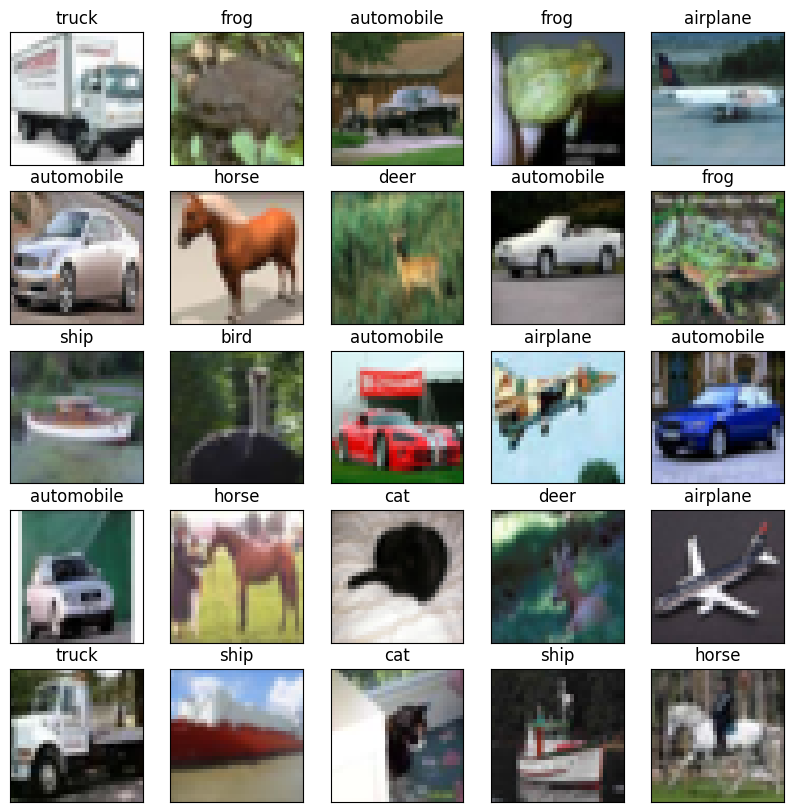

In [ ]:
### visualising random images from the training dataset.

# select row x column random indices
rows, columns = 5, 5
sample = np.random.randint(0, 10000, rows * columns)
# get images/labels at random indicies
preview_images = images[sample]
preview_labels = [labels[0][i] for i in sample]
# 10 x 10 grid figure
fig=plt.figure(figsize=(10, 10))
# display 25 random images
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(preview_images[i-1])
    plt.xticks([])
    plt.yticks([])
    plt.title(label_names[preview_labels[i-1]])
plt.show()

###CNN

### The first block of code is building the convolutional base for the model.

 So essentially, the CNN model has two parts. One is the convolutional base part in which we try to reduce the number of nodes/parameters whihc will be fed into the neural network. Then the second part is actually building the neural network which predicts the class of the image based on the features.

In [ ]:
### creating the cnn model
def create_model(dropout_1=0.1, dropout_2=0.3, passed_optimizer='adam'):
  cnn_model = models.Sequential()
  cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  cnn_model.add(layers.AveragePooling2D((2, 2)))
  cnn_model.add(layers.Dropout(dropout_1))
  cnn_model.add(layers.Conv2D(96, (3, 3), activation='relu'))
  cnn_model.add(layers.AveragePooling2D((2, 2)))
  cnn_model.add(layers.BatchNormalization())
  cnn_model.add(layers.Conv2D(96, (3, 3), activation='relu'))
  cnn_model.add(layers.AveragePooling2D((2, 2)))
  cnn_model.add(layers.Dropout(dropout_2))
  cnn_model.add(layers.BatchNormalization())
  cnn_model.add(layers.Flatten())
  cnn_model.add(layers.Dense(128, activation='relu'))
  cnn_model.add(layers.Dense(10, activation='softmax'))
  cnn_model.compile(optimizer=passed_optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  return cnn_model


In [ ]:
### using the early stopping function to prevent overfitting and then train the model.
callback_cnn = keras.callbacks.EarlyStopping(monitor='val_accuracy', restore_best_weights=True, start_from_epoch=10, patience=2)
base_model = create_model()
# base_model.summary()
base_trained_model = base_model.fit(np.array(training_dataset / 255.0), np.array(training_labels), epochs=20, validation_data=(test_images_indexed / 255.0, np.array(test_labels_indexed)), callbacks=[callback_cnn])

Epoch 1/50
1563/1563 [==============================] - 13s 7ms/step - loss: 1.5322 - accuracy: 0.4480 - val_loss: 1.2094 - val_accuracy: 0.5609
Epoch 2/50
1563/1563 [==============================] - 9s 6ms/step - loss: 1.1681 - accuracy: 0.5862 - val_loss: 1.1196 - val_accuracy: 0.5965
Epoch 3/50
1563/1563 [==============================] - 11s 7ms/step - loss: 1.0133 - accuracy: 0.6431 - val_loss: 0.9585 - val_accuracy: 0.6620
Epoch 4/50
1563/1563 [==============================] - 10s 6ms/step - loss: 0.9145 - accuracy: 0.6767 - val_loss: 1.0019 - val_accuracy: 0.6524
Epoch 5/50
1563/1563 [==============================] - 9s 6ms/step - loss: 0.8563 - accuracy: 0.6995 - val_loss: 0.8202 - val_accuracy: 0.7112
Epoch 6/50
1563/1563 [==============================] - 10s 7ms/step - loss: 0.7983 - accuracy: 0.7199 - val_loss: 0.7464 - val_accuracy: 0.7443
Epoch 7/50
1563/1563 [==============================] - 10s 6ms/step - loss: 0.7549 - accuracy: 0.7345 - val_loss: 0.8223 - val_accu

In [ ]:
### hyperparameter tuning for the CNN model for different drop-outs and optimizer.
model_1 = KerasClassifier(model=create_model, verbose=0)
parameters = {
     'model__dropout_1': [0.1, 0.2],
     'model__dropout_2': [0.3, 0.4],
     'model__passed_optimizer': ['adam', 'adadelta'],
}
grid = GridSearchCV(estimator=model_1, param_grid=parameters, cv=2, scoring='accuracy', verbose=3)
grid_results = grid.fit(np.array(training_dataset / 255.0), np.array(training_labels), validation_data=(test_images_indexed / 255.0, np.array(test_labels_indexed)))

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV 1/2] END model__dropout_1=0.1, model__dropout_2=0.3, model__passed_optimizer=adam;, score=0.303 total time= 1.2min
[CV 2/2] END model__dropout_1=0.1, model__dropout_2=0.3, model__passed_optimizer=adam;, score=0.446 total time=  10.9s
[CV 1/2] END model__dropout_1=0.1, model__dropout_2=0.3, model__passed_optimizer=adadelta;, score=0.128 total time=  11.5s
[CV 2/2] END model__dropout_1=0.1, model__dropout_2=0.3, model__passed_optimizer=adadelta;, score=0.100 total time=  15.4s
[CV 1/2] END model__dropout_1=0.1, model__dropout_2=0.4, model__passed_optimizer=adam;, score=0.404 total time=  15.5s
[CV 2/2] END model__dropout_1=0.1, model__dropout_2=0.4, model__passed_optimizer=adam;, score=0.283 total time=  11.6s
[CV 1/2] END model__dropout_1=0.1, model__dropout_2=0.4, model__passed_optimizer=adadelta;, score=0.159 total time=  15.6s
[CV 2/2] END model__dropout_1=0.1, model__dropout_2=0.4, model__passed_optimizer=adadelta;, sco

In [ ]:
### If the base model parameters are not the same as best parameters, then we train the new model
print(grid_results.best_estimator_)
print(grid_results.best_params_)
dp_1, dp_2, best_optimizer= grid_results.best_params_['model__dropout_1'], grid_results.best_params_['model__dropout_2'], grid_results.best_params_['model__passed_optimizer']
print(dp_1, dp_2)
if dp_1 != 0.1 or dp_2 != 0.3 or best_optimizer !='adam':
  best_model = create_model(dp_1, dp_2, passed_optimizer=best_optimizer)
  best_model.summary()
  best_cnn_model_history = best_model.fit(np.array(training_dataset / 255.0), np.array(training_labels), epochs=20, validation_data=(test_images_indexed / 255.0, np.array(test_labels_indexed)), callbacks=[callback_cnn])
  model = best_model
else:
  best_cnn_model_history = base_trained_model
  model = base_model

In [ ]:
### plotting the accuracy vs epochs curve for the best CNN model

epochs_list_cnn = np.arange(1, len(np.asarray(best_cnn_model_history.history['val_accuracy']))+1)
plt.plot(epochs_list_cnn, np.asarray(best_cnn_model_history.history['val_accuracy']))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Epochs vs Accuracy plot for CNN model')

In [ ]:
### plotting the predicted of the labels along with the images
labels_predicted = model.predict(test_images_indexed / 255.0)
max_label = [label_names[np.argmax(label)] for label in labels_predicted]

  # visualize these random images
fig=plt.figure(figsize=(10, 10))
for i in range(0, columns*rows):
      fig.add_subplot(rows, columns, i+1)
      plt.imshow(test_images_indexed[i])
      plt.xticks([])
      plt.yticks([])
      plt.title("{}"
            .format(max_label[i]))
plt.show()
test_loss, test_accuracy = model.evaluate(test_images_indexed / 255.0, np.array(test_labels_indexed))
index_of_possible_labels = []
for i in range(num_cases_per_batch):
    index_max = list(labels_predicted[i]).index(max(labels_predicted[i]))
    index_of_possible_labels.append(index_max)
print('The accuracy is:- ', test_accuracy * 100, '%')
matrix = confusion_matrix(np.array(test_labels_indexed), index_of_possible_labels, normalize='true')
sb.heatmap(matrix, robust=True, center=0.15, annot=True, xticklabels=label_names, yticklabels=label_names,cbar=False, square=True)
print(classification_report(index_of_possible_labels, np.array(test_labels_indexed)))

### Naive Bayes Classifier model

In [ ]:
### Fitting the Gaussian Naive Bayes to the training dataset. We had to resize the training dataset since Gaussian Naive Bayes don't take
### tensors as the input.
nb = GaussianNB()
image_num, image_height, image_width, scale = training_dataset.shape
nb.fit(np.reshape(training_dataset, newshape=(image_num, image_height * image_width * scale)), np.squeeze(training_labels))

GaussianNB()

The accuracy of the Naive Bayes Classifier for Gaussian pdf is:-  29.759999999999998 %
              precision    recall  f1-score   support

           0       0.49      0.27      0.35      1817
           1       0.17      0.41      0.24       405
           2       0.08      0.19      0.12       443
           3       0.08      0.25      0.12       305
           4       0.42      0.24      0.30      1737
           5       0.26      0.31      0.29       840
           6       0.47      0.25      0.33      1846
           7       0.13      0.42      0.20       310
           8       0.47      0.39      0.42      1219
           9       0.41      0.38      0.39      1078

    accuracy                           0.30     10000
   macro avg       0.30      0.31      0.28     10000
weighted avg       0.39      0.30      0.32     10000



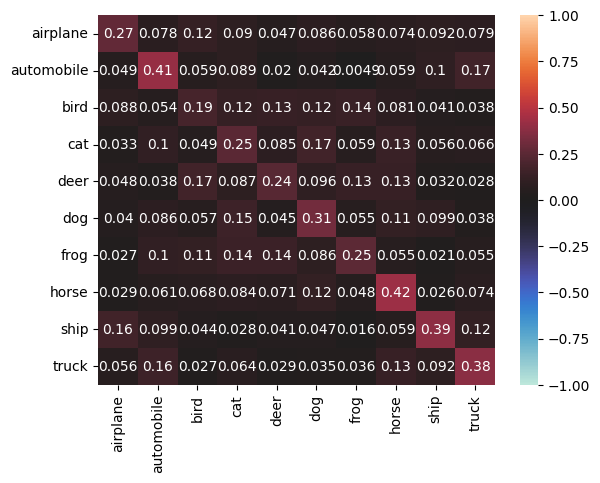

In [ ]:
### printing the accuracy of the Naive Bayes model
test_num, test_image_height, test_image_width, scale_test = test_images_indexed.shape
predicted_labels = nb.predict(test_images_indexed.reshape(test_num, test_image_height * test_image_width * scale_test))
print('The accuracy of the Naive Bayes Classifier for Gaussian pdf is:- ', accuracy_score(predicted_labels, test_labels_indexed) * 100, '%')
matrix_nb = confusion_matrix(np.array(predicted_labels), test_labels_indexed, normalize='true')
sb.heatmap(matrix_nb, vmin=-1, vmax=1, center=0, xticklabels=label_names, yticklabels=label_names, annot=True)
print(classification_report(predicted_labels, np.array(test_labels_indexed)))

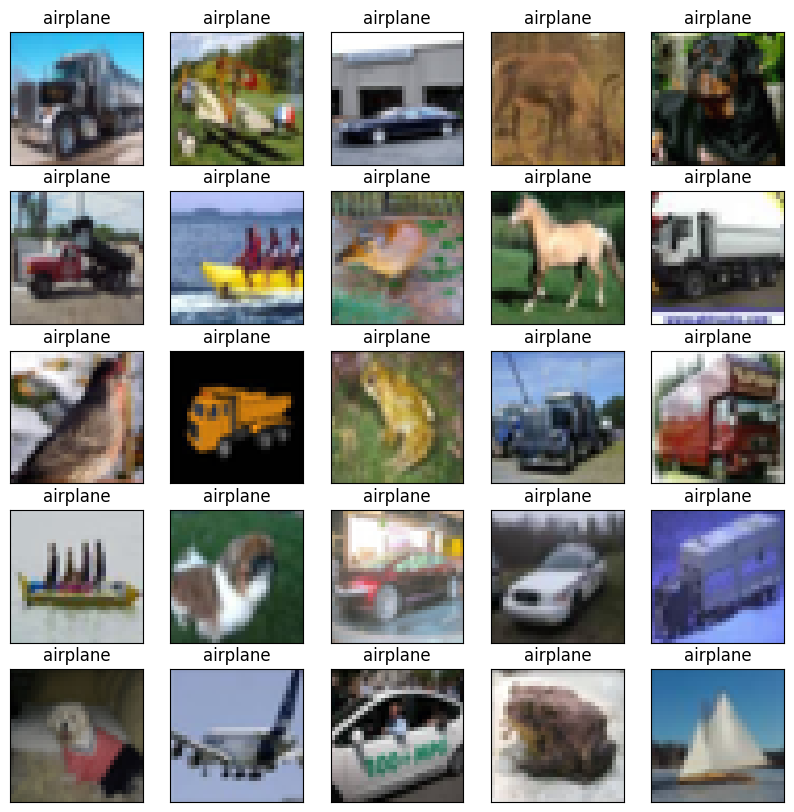

In [ ]:
### plotting the predicted of the labels along with the images
max_label = []
max_label = [label_names[np.argmax(label)] for label in predicted_labels]
# visualize these random images
fig=plt.figure(figsize=(10, 10))
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(test_images_indexed[i])
    plt.xticks([])
    plt.yticks([])
    plt.title("{}"
          .format(max_label[i]))
plt.show()

### KNN model

In [ ]:
##defines the knn model based on the neighbors and how to weigh each point in our neighborhood. We choose neighbors to be 10 because we have
### 10 labels and so the minimum number of clusters we can have is 10
knn_model = KNeighborsClassifier(n_neighbors=10, weights='uniform')
knn_model.fit(np.reshape(training_dataset, newshape=(image_num, image_height * image_width * scale)), np.squeeze(training_labels))
knn_prediction = knn_model.predict(test_images_indexed.reshape(test_num, test_image_height * test_image_width * scale_test))

In [ ]:
knn_accuracy = accuracy_score(np.array(test_labels_indexed), knn_prediction)
print('The accuracy for the KNN model is:- ', knn_accuracy * 100, '%\n')

The accuracy for the KNN model is:-  35.39 %



              precision    recall  f1-score   support

           0       0.48      0.42      0.45      1144
           1       0.22      0.65      0.33       336
           2       0.38      0.24      0.30      1584
           3       0.24      0.29      0.26       823
           4       0.46      0.25      0.32      1834
           5       0.29      0.36      0.32       798
           6       0.35      0.33      0.34      1075
           7       0.29      0.56      0.39       526
           8       0.62      0.40      0.49      1552
           9       0.20      0.61      0.30       328

    accuracy                           0.35     10000
   macro avg       0.35      0.41      0.35     10000
weighted avg       0.41      0.35      0.36     10000



<Axes: >

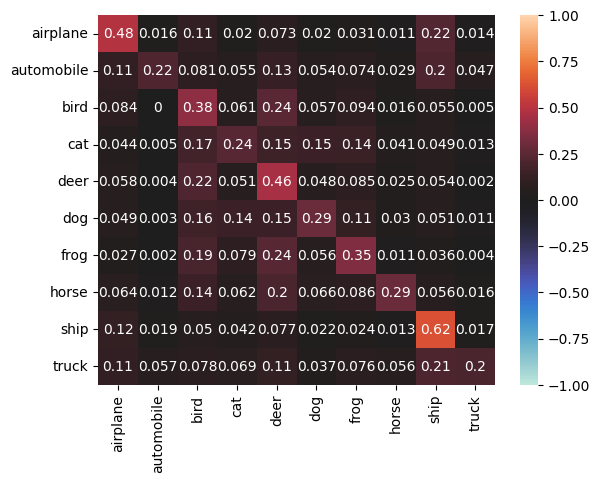

In [ ]:
print(classification_report(knn_prediction, np.array(test_labels_indexed)))
knn_matrix = confusion_matrix(np.array(test_labels_indexed), knn_prediction, normalize='true')
sb.heatmap(knn_matrix, vmin=-1, vmax=1, center=0, annot=True, xticklabels=label_names, yticklabels=label_names)

In [ ]:
### Hyperparameter tuning for the KNN model. We choose simpler parameters because the computation was taking a long time which
### made the GPU crash pretty often.
parameters = [{
    'n_neighbors': [2, 3, 4],
    'weights': ['uniform', 'distance']
}]
knn_model_optimized = KNeighborsClassifier()
grid_model = GridSearchCV(estimator=knn_model_optimized, param_grid=parameters, cv=2, return_train_score=True, verbose=3)
grid_model.fit(np.reshape(training_dataset, newshape=(image_num, image_height * image_width * scale)), np.squeeze(training_labels))

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END n_neighbors=2, weights=uniform;, score=(train=0.627, test=0.291) total time= 1.7min
[CV 2/2] END n_neighbors=2, weights=uniform;, score=(train=0.613, test=0.284) total time= 1.6min
[CV 1/2] END n_neighbors=2, weights=distance;, score=(train=1.000, test=0.322) total time= 1.6min
[CV 2/2] END n_neighbors=2, weights=distance;, score=(train=1.000, test=0.317) total time= 1.6min
[CV 1/2] END n_neighbors=3, weights=uniform;, score=(train=0.558, test=0.310) total time= 1.6min
[CV 2/2] END n_neighbors=3, weights=uniform;, score=(train=0.561, test=0.308) total time= 1.6min
[CV 1/2] END n_neighbors=3, weights=distance;, score=(train=1.000, test=0.328) total time= 1.6min
[CV 2/2] END n_neighbors=3, weights=distance;, score=(train=1.000, test=0.325) total time= 1.5min
[CV 1/2] END n_neighbors=4, weights=uniform;, score=(train=0.517, test=0.316) total time= 1.6min
[CV 2/2] END n_neighbors=4, weights=uniform;, score=(train=0.52

GridSearchCV(cv=2, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [2, 3, 4],
                          'weights': ['uniform', 'distance']}],
             return_train_score=True, verbose=3)

In [ ]:
### print the best parameters
print(grid_model.best_estimator_)
best_neighbors, best_weights_attribute = grid_model.best_params_['n_neighbors'], grid_model.best_params_['weights']
print(best_neighbors, best_weights_attribute)

KNeighborsClassifier(n_neighbors=4, weights='distance')
4 distance


In [ ]:
### predicting the labels using the KNN model
best_knn_model = KNeighborsClassifier(n_neighbors=best_neighbors, weights=best_weights_attribute)
best_knn_model.fit(np.reshape(training_dataset, newshape=(image_num, image_height * image_width * scale)), np.squeeze(training_labels))
knn_prediction_optimized = best_knn_model.predict(test_images_indexed.reshape(test_num, test_image_height * test_image_width * scale_test))

In [ ]:
### prints the accuracy of the best knn model
best_knn_accuracy = accuracy_score(np.array(test_labels_indexed), knn_prediction_optimized)
print('The accuracy for the KNN model after hyperparameter tuning is:- ', best_knn_accuracy * 100, '%\n')

The accuracy for the KNN model after hyperparameter tuning is:-  35.42 %



              precision    recall  f1-score   support

           0       0.49      0.44      0.47      1110
           1       0.20      0.70      0.32       291
           2       0.39      0.24      0.30      1591
           3       0.21      0.30      0.25       717
           4       0.50      0.24      0.33      2078
           5       0.28      0.39      0.32       706
           6       0.33      0.33      0.33      1001
           7       0.27      0.59      0.37       452
           8       0.69      0.39      0.50      1783
           9       0.19      0.69      0.29       271

    accuracy                           0.35     10000
   macro avg       0.35      0.43      0.35     10000
weighted avg       0.43      0.35      0.36     10000



<Axes: >

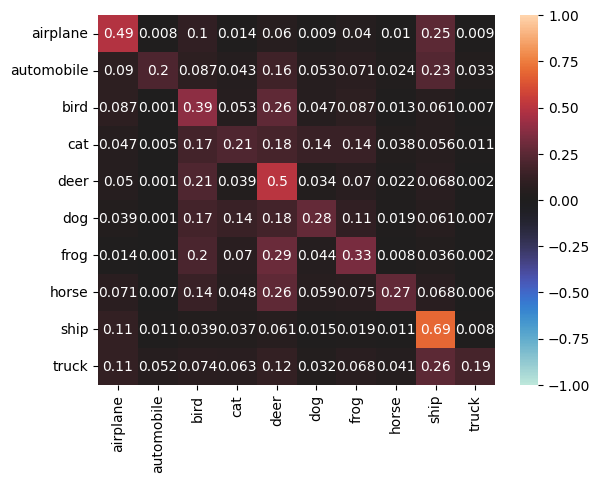

In [ ]:
### prints the classification report for the knn model.
print(classification_report(knn_prediction_optimized, np.array(test_labels_indexed)))
knn_matrix = confusion_matrix(np.array(test_labels_indexed), knn_prediction_optimized, normalize='true')
sb.heatmap(knn_matrix, vmin=-1, vmax=1, center=0, annot=True, xticklabels=label_names, yticklabels=label_names)

RNN-CNN model

In [ ]:
### define the rnn_cnn model
def rnn_cnn(repeated_vector_num = 1, lstm_value=256):
  rnn_cnn_model = models.Sequential()
  rnn_cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  rnn_cnn_model.add(layers.AveragePooling2D((2, 2)))
  rnn_cnn_model.add(layers.Dropout(dp_1))
  rnn_cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  rnn_cnn_model.add(layers.AveragePooling2D((2, 2)))
  rnn_cnn_model.add(layers.BatchNormalization())
  rnn_cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  rnn_cnn_model.add(layers.Dropout(dp_2))
  rnn_cnn_model.add(layers.AveragePooling2D((2, 2)))
  rnn_cnn_model.add(layers.BatchNormalization())
  rnn_cnn_model.add(layers.Flatten())
  rnn_cnn_model.add((layers.Dense(128, activation='relu')))
  rnn_cnn_model.add(tf.keras.layers.RepeatVector(repeated_vector_num))
  rnn_cnn_model.add(tf.keras.layers.LSTM(units=lstm_value))
  rnn_cnn_model.add(layers.Dense(10, activation='sigmoid'))
  rnn_cnn_model.compile(optimizer='adam',
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])
  return rnn_cnn_model


In [ ]:
### train the RNN-CNN model with the early stopping function to prevent overfitting
callback_r_cnn = keras.callbacks.EarlyStopping(monitor='val_accuracy', restore_best_weights=True, start_from_epoch=10, patience=2)
rnn_cnn_model = rnn_cnn()
rnn_cnn_model.summary()
trained_model = rnn_cnn_model.fit(np.array(training_dataset / 255.0), np.array(training_labels), epochs=20, validation_data=(test_images_indexed / 255.0, np.array(test_labels_indexed)), callbacks=callback_r_cnn)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_61 (Conv2D)          (None, 30, 30, 64)        1792      
                                                                 
 average_pooling2d_61 (Aver  (None, 15, 15, 64)        0         
 agePooling2D)                                                   
                                                                 
 dropout_40 (Dropout)        (None, 15, 15, 64)        0         
                                                                 
 conv2d_62 (Conv2D)          (None, 13, 13, 128)       73856     
                                                                 
 average_pooling2d_62 (Aver  (None, 6, 6, 128)         0         
 agePooling2D)                                                   
                                                                 
 batch_normalization_40 (Ba  (None, 6, 6, 128)       

In [ ]:
### Doing hyperparameter tuning for the RNN-CNN model with the LSTM value and how many times we need to feed the data into the model(repeated vector num)

rcmodel = KerasClassifier(model=rnn_cnn, verbose=0)
parameters= {
    'model__repeated_vector_num': [1, 8],
    'model__lstm_value': [128, 256],
}
rcgrid = GridSearchCV(estimator=rcmodel, param_grid=parameters, cv=2, scoring='accuracy', verbose=3)

In [ ]:

rc_grid_results = rcgrid.fit(np.array(training_dataset / 255.0), np.array(training_labels), validation_data=(test_images_indexed / 255.0, np.array(test_labels_indexed)))
best_lstm_value, best_repeated_vector_num = rc_grid_results.best_params_['model__lstm_value'], rc_grid_results.best_params_['model__repeated_vector_num']
print(best_lstm_value, best_repeated_vector_num)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2] END model__lstm_value=128, model__repeated_vector_num=1;, score=0.398 total time=  55.2s
[CV 2/2] END model__lstm_value=128, model__repeated_vector_num=1;, score=0.378 total time=  18.0s
[CV 1/2] END model__lstm_value=128, model__repeated_vector_num=8;, score=0.372 total time=  16.6s
[CV 2/2] END model__lstm_value=128, model__repeated_vector_num=8;, score=0.459 total time=  20.1s
[CV 1/2] END model__lstm_value=256, model__repeated_vector_num=1;, score=0.421 total time=  16.9s
[CV 2/2] END model__lstm_value=256, model__repeated_vector_num=1;, score=0.455 total time=  15.7s
[CV 1/2] END model__lstm_value=256, model__repeated_vector_num=8;, score=0.451 total time=  17.4s
[CV 2/2] END model__lstm_value=256, model__repeated_vector_num=8;, score=0.495 total time=  16.8s
256 8


In [ ]:
### if the base model parameters is not the same as the best models, then we train the model with the best parameters.
if best_repeated_vector_num != 1 or best_lstm_value != 256:
  rnn_cnn_model_tuned = rnn_cnn(repeated_vector_num=best_repeated_vector_num,
                             lstm_value=best_lstm_value)
  best_rnn_cnn_model_history = rnn_cnn_model_tuned.fit(np.array(training_dataset / 255.0),
                                  np.array(training_labels), epochs=20, validation_data=(test_images_indexed / 255.0, np.array(test_labels_indexed)), callbacks=callback_r_cnn)
  best_r_cnn_model = rnn_cnn_model_tuned
else:
  best_r_cnn_model = rnn_cnn_model
  best_rnn_cnn_model_history = trained_model

Epoch 1/20
1563/1563 [==============================] - 23s 12ms/step - loss: 1.4687 - accuracy: 0.4699 - val_loss: 1.3345 - val_accuracy: 0.5247
Epoch 2/20
1563/1563 [==============================] - 17s 11ms/step - loss: 1.1561 - accuracy: 0.5909 - val_loss: 1.2198 - val_accuracy: 0.5662
Epoch 3/20
1563/1563 [==============================] - 16s 10ms/step - loss: 1.0059 - accuracy: 0.6445 - val_loss: 1.0459 - val_accuracy: 0.6292
Epoch 4/20
1563/1563 [==============================] - 15s 10ms/step - loss: 0.9035 - accuracy: 0.6842 - val_loss: 0.8471 - val_accuracy: 0.7046
Epoch 5/20
1563/1563 [==============================] - 14s 9ms/step - loss: 0.8332 - accuracy: 0.7060 - val_loss: 0.8378 - val_accuracy: 0.7108
Epoch 6/20
1563/1563 [==============================] - 13s 9ms/step - loss: 0.7769 - accuracy: 0.7292 - val_loss: 0.8475 - val_accuracy: 0.7066
Epoch 7/20
1563/1563 [==============================] - 14s 9ms/step - loss: 0.7322 - accuracy: 0.7440 - val_loss: 0.8938 - va

313/313 [==============================] - 1s 4ms/step - loss: 0.6431 - accuracy: 0.7855
The accuracy for the RNN-CNN model on test data is:-  78.54999899864197 %
              precision    recall  f1-score   support

           0       0.80      0.85      0.83       941
           1       0.87      0.92      0.89       949
           2       0.70      0.69      0.70      1020
           3       0.60      0.60      0.60      1010
           4       0.75      0.77      0.76       980
           5       0.75      0.64      0.69      1167
           6       0.84      0.81      0.83      1042
           7       0.77      0.88      0.82       870
           8       0.91      0.87      0.89      1040
           9       0.86      0.88      0.87       981

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.78      0.79      0.78     10000



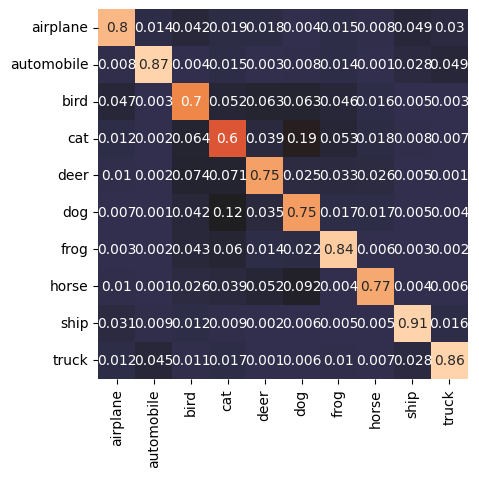

In [ ]:
### printing the classification report and confusion matrix for the best RNN-CNN model
labels_predicted = best_r_cnn_model.predict(test_images_indexed / 255.0)

### extracts the label with the maximum accuracy.
max_label = [label_names[np.argmax(label)] for label in labels_predicted]
index_of_possible_labels = []
for i in range(num_cases_per_batch):
  index_max = list(labels_predicted[i]).index(max(labels_predicted[i]))
  index_of_possible_labels.append(index_max)
test_loss_r_cnn, test_accuracy_r_cnn = best_r_cnn_model.evaluate(test_images_indexed / 255.0, np.array(test_labels_indexed))
print('The accuracy for the RNN-CNN model on test data is:- ', test_accuracy_r_cnn * 100, '%')
matrix = confusion_matrix(np.array(test_labels_indexed), index_of_possible_labels, normalize='true')
sb.heatmap(matrix, robust=True, center=0.15, annot=True, xticklabels=label_names, yticklabels=label_names, cbar=False, square=True)
print(classification_report(index_of_possible_labels, np.array(test_labels_indexed)))

Text(0.5, 1.0, 'Epochs vs Accuracy plot for RNN-CNN model')

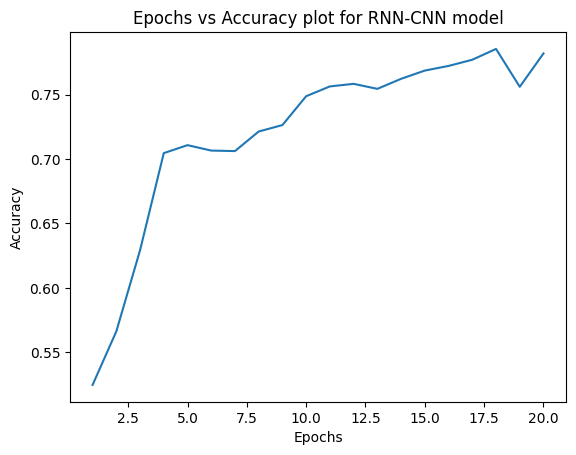

In [ ]:
### plot the accuracy vs the epoch curve for the RNN-CNN model.
epochs_list_rnn_cnn = np.arange(1, len(np.asarray(best_rnn_cnn_model_history.history['val_accuracy']))+1)
plt.plot(epochs_list_rnn_cnn, np.asarray(best_rnn_cnn_model_history.history['val_accuracy']))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Epochs vs Accuracy plot for RNN-CNN model')

In [ ]:
### save the model using .save function.
best_r_cnn_model.save('rnn_cnn.keras')